In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler

## **Preprocessing**

In [2]:
#loading the data
df_train = pd.read_csv('../input/dapprojekt22/train.csv')
df_test = pd.read_csv('../input/dapprojekt22/test.csv')

df_train.head()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WINNER,NEXT_WEIGHT
0,17,17,0.472,0.500,12.7,13.8,0.89,0.81,18,6,...,19,14,0.452,0.424,0.197,0.198,MIA,CHI,0.0,1.489674
1,23,26,0.657,0.703,17.0,19.9,1.21,1.30,7,4,...,18,26,0.375,0.591,0.198,0.196,LAL,LAC,0.0,5.361710
2,27,23,0.659,0.548,19.8,15.6,1.69,1.21,6,4,...,18,27,0.462,0.435,0.200,0.200,CLE,BKN,0.0,2.357026
3,24,21,0.727,0.600,18.2,15.7,1.60,1.50,3,8,...,20,21,0.426,0.525,0.200,0.195,PHI,MIA,0.0,5.980445
4,30,24,0.714,0.558,21.5,18.1,1.58,1.33,1,0,...,32,26,0.485,0.520,0.200,0.200,TOR,BOS,0.0,1.283159


In [3]:
# dropping missing values
df_missing = df_train.isna().sum()[df_train.isna().sum() != 0]

df_train.drop(columns=df_missing.index.values, inplace=True)
df_test.drop(columns=df_missing.index.values, inplace=True)

In [4]:
# removing constant features and monotonous ones
df_nunique1 = df_train.nunique()[df_train.nunique() == 1]
df_nunique3000 = df_train.nunique()[df_train.nunique() >= 3000]

df_train.drop(columns=df_nunique1.index.values, inplace=True)
df_test.drop(columns=df_nunique1.index.values, inplace=True)

df_train.drop(columns=df_nunique3000.index.values, inplace=True)
df_test.drop(columns=df_nunique3000.index.values, inplace=True)

In [5]:
# change min_home and min_away from categorical to integer
df_train['MIN_HOME'] = np.int32(df_train['MIN_HOME'].str.split(':').str[0])
df_train['MIN_AWAY'] = np.int32(df_train['MIN_AWAY'].str.split(':').str[0])

df_test['MIN_HOME'] = np.int32(df_test['MIN_HOME'].str.split(':').str[0])
df_test['MIN_AWAY'] = np.int32(df_test['MIN_AWAY'].str.split(':').str[0])

In [6]:
# save and drop categoricals from train
df_categorical_train = df_train.select_dtypes(include=['object']).copy()
df_categorical_test = df_test.select_dtypes(include=['object']).copy()

df_train.drop(columns=df_categorical_train.columns.values.tolist(), inplace=True)
df_test.drop(columns=df_categorical_test.columns.values.tolist(), inplace=True)

In [7]:
# drop next weight
df_train.drop(columns=['NEXT_WEIGHT'], inplace=True)

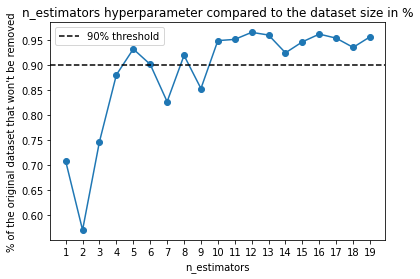

In [8]:
# detect outliers
d = {}
df_train_wo_nw = df_train.loc[:, df_train.columns != 'NEXT_WINNER']
for i in range(1, 20):
    lof = IsolationForest(n_estimators=i)
    X_out = lof.fit_predict(df_train_wo_nw)
    d[i] = np.sum(X_out == 1)/len(X_out)

plt.plot(list(d.keys()), list(d.values()), '-o')
plt.xticks(list(d.keys()))
plt.xlabel('n_estimators')
plt.ylabel('% of the original dataset that won\'t be removed')
plt.title('n_estimators hyperparameter compared to the dataset size in %')
plt.axhline(y=0.9, c='k', linestyle='dashed', label='90% threshold')
plt.legend()
plt.show()

In [9]:
# remove outliers
lof = IsolationForest(n_estimators=6)
X_out = lof.fit_predict(df_train_wo_nw)
rows_to_drop = np.where(X_out == -1)[0]

df_train.drop(df_train.index[list(rows_to_drop)], inplace=True)
df_categorical_train.drop(df_categorical_train.index[list(rows_to_drop)], inplace=True)

In [10]:
# remove id variables
df_train.drop(columns=['TEAM_ID_AWAY', 'TEAM_ID_HOME'], inplace=True)
df_test.drop(columns=['TEAM_ID_AWAY', 'TEAM_ID_HOME'], inplace=True)

In [11]:
df_train = pd.concat((df_categorical_train[['TEAM_ABBREVIATION_AWAY', 'TEAM_ABBREVIATION_HOME']], df_train), axis=1)
df_test = pd.concat((df_categorical_test[['TEAM_ABBREVIATION_AWAY', 'TEAM_ABBREVIATION_HOME']], df_test), axis=1)

df_train.head()

,TEAM_ABBREVIATION_AWAY,TEAM_ABBREVIATION_HOME,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,...,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_WINNER
0,ORL,IND,17,17,0.472,0.500,12.7,13.8,0.89,0.81,...,0.570,42,33,19,14,0.452,0.424,0.197,0.198,0.0
1,CHI,MIA,23,26,0.657,0.703,17.0,19.9,1.21,1.30,...,0.631,48,44,18,26,0.375,0.591,0.198,0.196,0.0
2,LAC,LAL,27,23,0.659,0.548,19.8,15.6,1.69,1.21,...,0.551,39,62,18,27,0.462,0.435,0.200,0.200,0.0
3,BKN,CLE,24,21,0.727,0.600,18.2,15.7,1.60,1.50,...,0.495,47,40,20,21,0.426,0.525,0.200,0.195,0.0
4,MIA,PHI,30,24,0.714,0.558,21.5,18.1,1.58,1.33,...,0.629,66,50,32,26,0.485,0.520,0.200,0.200,0.0


In [12]:
df_train.reset_index(drop=True, inplace=True)
df_train.head()

,TEAM_ABBREVIATION_AWAY,TEAM_ABBREVIATION_HOME,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,...,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_WINNER
0,ORL,IND,17,17,0.472,0.500,12.7,13.8,0.89,0.81,...,0.570,42,33,19,14,0.452,0.424,0.197,0.198,0.0
1,CHI,MIA,23,26,0.657,0.703,17.0,19.9,1.21,1.30,...,0.631,48,44,18,26,0.375,0.591,0.198,0.196,0.0
2,LAC,LAL,27,23,0.659,0.548,19.8,15.6,1.69,1.21,...,0.551,39,62,18,27,0.462,0.435,0.200,0.200,0.0
3,BKN,CLE,24,21,0.727,0.600,18.2,15.7,1.60,1.50,...,0.495,47,40,20,21,0.426,0.525,0.200,0.195,0.0
4,MIA,PHI,30,24,0.714,0.558,21.5,18.1,1.58,1.33,...,0.629,66,50,32,26,0.485,0.520,0.200,0.200,0.0


In [13]:
df_train.columns.tolist()

['TEAM_ABBREVIATION_AWAY',
 'TEAM_ABBREVIATION_HOME',
 'AST_AWAY',
 'AST_HOME',
 'AST_PCT_AWAY',
 'AST_PCT_HOME',
 'AST_RATIO_AWAY',
 'AST_RATIO_HOME',
 'AST_TOV_AWAY',
 'AST_TOV_HOME',
 'BLKA_AWAY',
 'BLKA_HOME',
 'BLK_AWAY',
 'BLK_HOME',
 'CFGA_AWAY',
 'CFGA_HOME',
 'CFGM_AWAY',
 'CFGM_HOME',
 'CFG_PCT_AWAY',
 'CFG_PCT_HOME',
 'DEF_RATING_AWAY',
 'DEF_RATING_HOME',
 'DFGA_AWAY',
 'DFGA_HOME',
 'DFGM_AWAY',
 'DFGM_HOME',
 'DFG_PCT_AWAY',
 'DFG_PCT_HOME',
 'DIST_AWAY',
 'DIST_HOME',
 'DRBC_AWAY',
 'DRBC_HOME',
 'DREB_AWAY',
 'DREB_HOME',
 'DREB_PCT_AWAY',
 'DREB_PCT_HOME',
 'EFG_PCT_AWAY',
 'EFG_PCT_HOME',
 'FG3A_AWAY',
 'FG3A_HOME',
 'FG3M_AWAY',
 'FG3M_HOME',
 'FG3_PCT_AWAY',
 'FG3_PCT_HOME',
 'FGA_AWAY',
 'FGA_HOME',
 'FGM_AWAY',
 'FGM_HOME',
 'FG_PCT_AWAY',
 'FG_PCT_HOME',
 'FTAST_AWAY',
 'FTAST_HOME',
 'FTA_AWAY',
 'FTA_HOME',
 'FTA_RATE_AWAY',
 'FTA_RATE_HOME',
 'FTM_AWAY',
 'FTM_HOME',
 'FT_PCT_AWAY',
 'FT_PCT_HOME',
 'MIN_AWAY',
 'MIN_HOME',
 'NET_RATING_AWAY',
 'NET_RATING_HOM

In [14]:
print(df_categorical_train.shape)
print(df_train.shape)

(3451, 8)
(3451, 167)


In [15]:
import warnings
warnings.filterwarnings('ignore')

def calculate_features_for_set(df, d, start=1, window=1000):
    home, away = 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY'
    home_col = [i for i in filter(lambda x: x.endswith('HOME'), df.columns.tolist())]
    away_col = [i for i in filter(lambda x: x.endswith('AWAY'), df.columns.tolist())]
    
    print('Calculating features for dataset . . .')
    for i in range(start + window, df.shape[0]):
        if i % 400 == 399:
            print(f'Iteration {i+1}')
        
        rows_before = df.loc[i-window:i-1]
        row_curr = df.loc[i]
        
        curr_home, curr_away = row_curr[home], row_curr[away]
        
        mask1 = (rows_before[home] == curr_home) & (rows_before[away] == curr_away)
        mask2 = (rows_before[away] == curr_home) & (rows_before[home] == curr_away)
        
        rows_home = rows_before[mask1]
        rows_away = rows_before[mask2]
        
        if rows_home.empty and rows_away.empty:
            [d[k].append(0) for k in d.keys()]
        
        elif rows_home.empty:
            res = rows_away.mean()
            for i, k in enumerate(d.keys()):
                k2 = k.replace('AWAY', 'HOME') if 'AWAY' in k else k.replace('HOME', 'AWAY')
                d[k2].append(res[k])
                    
        elif rows_away.empty:
            res = rows_home.mean()
            [d[k].append(res[k]) for i, k in enumerate(d.keys())]
        
        else:
            res1 = rows_away.mean()
            res2 = rows_home.mean()
            for i, k in enumerate(d.keys()):
                k2 = k.replace('AWAY', 'HOME') if 'AWAY' in k else k.replace('HOME', 'AWAY')
                d[k].append((res1[k2] + res2[k])/2)
            
    return pd.DataFrame.from_dict(d)

def define_features(df_train, df_test):
    data_train = {}
    data_test = {}
    
    # shifting makes calculating the features easier
    y_train = df_train['NEXT_WINNER'][:-1]
    x_train = df_train[1:].reset_index(drop=True)
    x_train.drop(columns=['NEXT_WINNER'], inplace=True)
    train_shifted = pd.concat((x_train, y_train), axis=1)
    merged = pd.concat((train_shifted, df_test)).drop(columns=['id']).reset_index(drop=True)

    home, away = 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY'
   
    cols = [i for i in train_shifted.columns.tolist() if i != home and i != away and i != 'NEXT_WINNER']
    for c in cols:
        data_train[c] = []
        data_test[c] = []
    
    df_train_features = calculate_features_for_set(train_shifted, data_train)
    df_test_features = calculate_features_for_set(merged, data_test, start=len(train_shifted), window=0)
    
    return df_train_features, df_test_features

In [16]:
start = time.time()
df_train_features, df_test_features = define_features(df_train, df_test)
end = time.time()
print(f'Time for executing the function {end-start}s')

Calculating features for dataset . . .
Iteration 1200
Iteration 1600
Iteration 2000
Iteration 2400
Iteration 2800
Iteration 3200
Calculating features for dataset . . .
Iteration 3600
Iteration 4000
Iteration 4400
Time for executing the function 20.52962827682495s


In [17]:
df_train_features.tail()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,TS_PCT_AWAY,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME
2444,27.50,16.0,0.6980,0.40600,19.950,13.05,1.5500,1.070,5.5,6.0,...,0.595,0.5995,48.5,29.00,22.50,16.0,0.46450,0.556,0.197,0.1980
2445,21.75,23.5,0.5000,0.62525,16.575,17.80,3.4675,1.865,7.5,4.0,...,0.571,0.5465,51.0,40.25,25.75,16.0,0.50375,0.397,0.200,0.1995
2446,0.00,0.0,0.0000,0.00000,0.000,0.00,0.0000,0.000,0.0,0.0,...,0.000,0.0000,0.0,0.00,0.00,0.0,0.00000,0.000,0.000,0.0000
2447,0.00,0.0,0.0000,0.00000,0.000,0.00,0.0000,0.000,0.0,0.0,...,0.000,0.0000,0.0,0.00,0.00,0.0,0.00000,0.000,0.000,0.0000
2448,20.00,22.5,0.5645,0.55600,15.450,17.40,1.8250,1.780,4.5,5.5,...,0.532,0.5910,42.0,48.00,19.00,24.0,0.45350,0.502,0.199,0.1980


## **Classification using neural networks**

Neural networks are a highly customizable and powerful classifier and here we'll dive deeper in how they work.

#### **Forward pass**:

At the input of a neural network there is the data. We send this data in batches (mini-groups) through the network. The network calculates the linear combination of the weights and the input and adds the bias. After this comes an activation function. These functions are used to add nonlinearity to the decision boundary. Most often we use the ReLU or tangent hyperbolic functions. Now this vector becomes the input of the next layer and process repeats. The difference is in the last layer where we usually abandon the aforementioned activation functions and use the sigmoid (2 classes) or softmax function (>2 classes) in classification problems.

If we're talking about a 2 layer fully connected neural network with ReLU activations and a softmax, we can define the equations as:
$$\mathbf{s}_1 = W_1\mathbf{x} + \mathbf{b}_1$$
$$\mathbf{h}_1 = ReLU(\mathbf{h}_1)$$
$$\mathbf{s}_2 = W_2\mathbf{h}_1 + \mathbf{b}_2$$
$$\mathbf{o} = softmax(\mathbf{s}_2)$$

#### **Loss function**

The forward pass takes care of the predictions, but we would like to know how "bad" are our prediction actually is, otherwise we can't start learning. This is where the loss function comes into play. The usual loss function for classification is the cross entropy loss which is defined as:
$$L(y, \hat{y}) = - \sum_{i=1}^{K} y_i log(\hat{y_i})$$
This can be derived by assuming a Bernoulli distribution of the labels and using negative log loss.


#### **Backpropagation**

Backpropagation is the algorithm for determining the gradients with respect to parameters and inputs of the network. This is used in combination with an optimization algorithm to learn.



All of this can easily be implemented through different frameworks. I'll use Keras which is a high level framework. Some other well know frameworks are MXnet, PyTorch and Tensorflow. Let's use the architecture from the forward pass section.

In [18]:
y_train = df_train['NEXT_WINNER'][:-1]
y_train = y_train.loc[1001:]

In [19]:
print(y_train.shape, df_train_features.shape)

(2449,) (2449, 164)


In [20]:
last = int(df_train_features.shape[0]*0.75)
df_val_features = df_train_features[last:]
df_train_features = df_train_features[0:last]

In [21]:
y_val = y_train[last:]
y_train = y_train[0:last]

In [22]:
y_val = y_val.apply(lambda x: int(x))
y_train = y_train.apply(lambda x: int(x))

In [23]:
scaler = StandardScaler()
df_train_features = scaler.fit_transform(df_train_features)
df_val_features = scaler.transform(df_val_features)
df_test_features = scaler.transform(df_test_features)

df_train_features

array([[-3.2595975 , -3.21988694, -3.48518567, ..., -3.53717769,
        -4.03861429, -4.0386167 ],
       [ 0.95895419,  0.51651375,  1.12286703, ...,  0.97329479,
         0.22991532,  0.27361075],
       [-0.05662307,  0.20514703,  0.3054111 , ...,  0.38590436,
         0.25147355,  0.23048848],
       ...,
       [ 0.64646888,  0.04946367, -0.14276936, ...,  0.1929659 ,
         0.27303178,  0.27361075],
       [ 0.64646888, -0.41758642,  0.10025807, ..., -0.48446247,
         0.18679886,  0.27361075],
       [ 1.58392481,  0.20514703,  0.965057  , ...,  0.21869103,
         0.22991532,  0.1873662 ]])

We can check out the validation set performance on a baseline such as the logistic regression model. A neat way to evaluate all models is to use the classification_report function. It tells you all about precision, recall, f1-score and accuracy.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def eval_model(model, df_train_features, y_train, df_val_features, y_val, exp=False):
    y_train_pred = (model.predict(df_train_features)>0.5).astype(int).flatten()
    print('--------------------------- TRAIN ----------------------------\n')
    print(classification_report(y_train, y_train_pred), 2*'\n')

    y_val_pred = (model.predict(df_val_features)>0.5).astype(int).flatten()
    print('------------------------ VALIDATION --------------------------\n')
    print(classification_report(y_val, y_val_pred))
    
    
model = LogisticRegression()
model.fit(df_train_features, y_train)
eval_model(model, df_train_features, y_train, df_val_features, y_val)

--------------------------- TRAIN ----------------------------

              precision    recall  f1-score   support

           0       0.66      0.82      0.73      1060
           1       0.63      0.41      0.50       776

    accuracy                           0.65      1836
   macro avg       0.64      0.62      0.61      1836
weighted avg       0.65      0.65      0.63      1836
 


------------------------ VALIDATION --------------------------

              precision    recall  f1-score   support

           0       0.63      0.82      0.72       365
           1       0.54      0.31      0.39       248

    accuracy                           0.61       613
   macro avg       0.59      0.56      0.55       613
weighted avg       0.59      0.61      0.58       613



In [25]:
from keras.layers import Dense, GRU, LSTM, RNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import metrics

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

model = keras.models.Sequential([
    Dense(100, activation='relu', input_shape=(df_train_features.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = SGD(lr=LEARNING_RATE)
)

history = model.fit(
    x = df_train_features, 
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=(df_val_features, y_val)
)

2022-05-24 08:58:14.290800: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-24 08:58:14.449074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
58/58 [==============================] - 1s 6ms/step - loss: 0.7231 - val_loss: 0.6894
Epoch 2/30
58/58 [==============================] - 0s 3ms/step - loss: 0.7096 - val_loss: 0.6867
Epoch 3/30
58/58 [==============================] - 0s 3ms/step - loss: 0.7060 - val_loss: 0.6833
Epoch 4/30
58/58 [==============================] - 0s 3ms/step - loss: 0.7035 - val_loss: 0.6814
Epoch 5/30
58/58 [==============================] - 0s 3ms/step - loss: 0.7009 - val_loss: 0.6775
Epoch 6/30
58/58 [==============================] - 0s 3ms/step - loss: 0.6987 - val_loss: 0.6759
Epoch 7/30
58/58 [==============================] - 0s 3ms/step - loss: 0.6964 - val_loss: 0.6743
Epoch 8/30
58/58 [==============================] - 0s 3ms/step - loss: 0.6945 - val_loss: 0.6733
Epoch 9/30
58/58 [==============================] - 0s 3ms/step - loss: 0.6922 - val_loss: 0.6685
Epoch 10/30
58/58 [==============================] - 0s 3ms/step - loss: 0.6911 - val_loss: 0.6679
Epoch 11/30
58/58 [

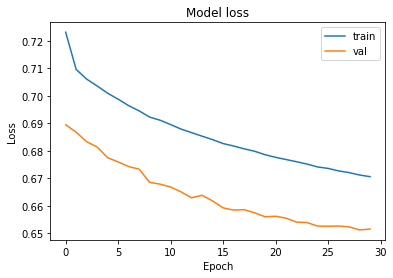

In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.show()

plot_loss(history)

Usually deeper architectures are preferred because they can model more complex decision functions. We can also add regularization and dropouts to make sure our model is robust. Regularization is adding a scaled norm of the weights to the loss function while dropouts randomly ignore some of the outputs of the past layer.

Besides, Keras also supports using pretrained architectures (https://keras.io/api/applications/) which you may find useful for achieving higher accuracies.

In [27]:
from keras.layers import Dropout

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 5e-3

model = keras.models.Sequential([
    Dense(2048, activation='relu', input_shape=(df_train_features.shape[1],)),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(rate=0.25),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(rate=0.25),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = Adam(lr=LEARNING_RATE),
)

history = model.fit(
    df_train_features, y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=(df_val_features, y_val)
)

Epoch 1/30
58/58 [==============================] - 3s 30ms/step - loss: 0.7916 - val_loss: 0.6553
Epoch 2/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6832 - val_loss: 0.6832
Epoch 3/30
58/58 [==============================] - 2s 40ms/step - loss: 0.6843 - val_loss: 0.6773
Epoch 4/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6938 - val_loss: 0.6766
Epoch 5/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6814 - val_loss: 0.6737
Epoch 6/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6825 - val_loss: 0.6771
Epoch 7/30
58/58 [==============================] - 2s 26ms/step - loss: 0.6838 - val_loss: 0.6765
Epoch 8/30
58/58 [==============================] - 2s 26ms/step - loss: 0.6815 - val_loss: 0.6758
Epoch 9/30
58/58 [==============================] - 2s 28ms/step - loss: 0.6812 - val_loss: 0.6755
Epoch 10/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6813 - val_loss: 0.6755
Epoch 11/

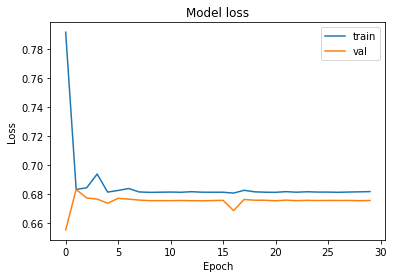

In [28]:
plot_loss(history)

In [29]:
eval_model(model, df_train_features, y_train, df_val_features, y_val)

--------------------------- TRAIN ----------------------------

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1060
           1       0.00      0.00      0.00       776

    accuracy                           0.58      1836
   macro avg       0.29      0.50      0.37      1836
weighted avg       0.33      0.58      0.42      1836
 


------------------------ VALIDATION --------------------------

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       365
           1       0.00      0.00      0.00       248

    accuracy                           0.60       613
   macro avg       0.30      0.50      0.37       613
weighted avg       0.35      0.60      0.44       613



We can see that the deeper architecture helps with the performance and that the dropout layers deal with the consistency of the results on the validation set.

Next thing we can try and employ are RNNs. I won't go too much into detail but the key difference compared to is that they use 2 inputs: the past hidden state and the current input. These are often used in NLP and time series forecasting. There are also different types of cells we can use with RNNs such as GRU, LSTM and RNN cells. Let's create a model using these cells and evaluate it.

In [50]:
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
TIMESTEP = 20

model = keras.models.Sequential([
    LSTM(128, input_shape=(TIMESTEP, df_train_features.shape[1]), activation='tanh', return_sequences=True),
    LSTM(128, activation='tanh'),
    Dropout(rate=0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = Adam(lr=LEARNING_RATE),
)

history = model.fit(
    np.expand_dims(df_train_features, 1), y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=(np.expand_dims(df_val_features, 1), y_val)
)

Epoch 1/25
58/58 [==============================] - 6s 25ms/step - loss: 0.6932 - val_loss: 0.6912
Epoch 2/25
58/58 [==============================] - 1s 10ms/step - loss: 0.6909 - val_loss: 0.6880
Epoch 3/25
58/58 [==============================] - 1s 9ms/step - loss: 0.6884 - val_loss: 0.6846
Epoch 4/25
58/58 [==============================] - 1s 10ms/step - loss: 0.6856 - val_loss: 0.6809
Epoch 5/25
58/58 [==============================] - 1s 9ms/step - loss: 0.6823 - val_loss: 0.6766
Epoch 6/25
58/58 [==============================] - 1s 10ms/step - loss: 0.6788 - val_loss: 0.6715
Epoch 7/25
58/58 [==============================] - 1s 9ms/step - loss: 0.6749 - val_loss: 0.6664
Epoch 8/25
58/58 [==============================] - 1s 9ms/step - loss: 0.6711 - val_loss: 0.6608
Epoch 9/25
58/58 [==============================] - 1s 9ms/step - loss: 0.6673 - val_loss: 0.6564
Epoch 10/25
58/58 [==============================] - 1s 9ms/step - loss: 0.6645 - val_loss: 0.6530
Epoch 11/25
58/

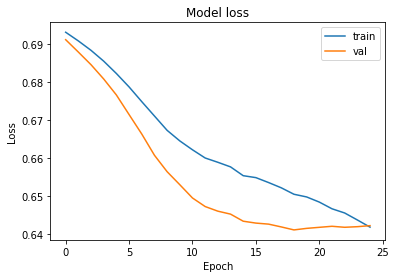

In [51]:
plot_loss(history)

In [61]:
#### POTREBNO DODATI EVALUACIJU ZA RNN ####
df_train_features2 = np.expand_dims(df_train_features, 1)
df_val_features2 = np.expand_dims(df_val_features, 1)

eval_model(model, df_train_features2, y_train, df_val_features2, y_val)

--------------------------- TRAIN ----------------------------

              precision    recall  f1-score   support

           0       0.64      0.84      0.73      1060
           1       0.62      0.36      0.46       776

    accuracy                           0.64      1836
   macro avg       0.63      0.60      0.59      1836
weighted avg       0.63      0.64      0.61      1836
 


------------------------ VALIDATION --------------------------

              precision    recall  f1-score   support

           0       0.65      0.86      0.74       365
           1       0.61      0.33      0.43       248

    accuracy                           0.64       613
   macro avg       0.63      0.59      0.58       613
weighted avg       0.63      0.64      0.61       613

